<font  style="font-size: 3rem; color: darkviolet"> Convolutional Neural Networks in TensorFlow - *part 1* </font>

DEL - 2023/24 - TP2 (1h30)

*This assignement is inspired by the Deep Learning course on Coursera by Andrew Ng, Stanford University, for which we are thankful.*

In this assignment, you will gain practical experience in constructing and training Convolutional Neural Networks (ConvNets) using the TensorFlow Keras Sequential API. This API offers an intuitive and straightforward approach to constructing and training ConvNets within the TensorFlow framework. It is suited for tasks that involve a sequential flow, where each layer has precisely one input tensor and one output tensor.

You can access the documentation for the Sequential API at the following link: https://www.tensorflow.org/guide/keras/sequential_model

You will develop a binary classifier utilizing the Sequential API to determine the emotional state of an individual as either positive or negative. 

### Table of Contents
- [1 - The Happy House Dataset](#1)
- [2 - Creating the Sequential Model](#2)
- [3 - Training and Evaluating the Model](#3)

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from data.test_utils import summary, comparator

%matplotlib inline
np.random.seed(1)

<a name='1'></a>
## <font color='darkviolet'> 1 - The Happy House Dataset

The Happy House dataset is a collection of facial images, and your task is to develop a ConvNet capable of effectively determining whether the individuals in these images are smiling or not. This task holds significance, as only those with a genuine smile will gain access to the Happy House.

In [2]:
# Run the following lines to load the training and test datasets
train_dataset = h5py.File('data/train_happy.h5', "r")
test_dataset = h5py.File('data/test_happy.h5', "r")

# Retrieve the keys within a HDF5 file
dataset_keys = list(train_dataset.keys())
print(dataset_keys[:])

['list_classes', 'train_set_x', 'train_set_y']


<a name='ex-1'></a>
### <font color='blue'> Exercise 1 - load_happy_dataset

<font color='blue'>**1.1** <font color='black'> Implement a function, `load_happy_dataset`, that loads both the training and test datasets from the provided external files: extract the features and labels for both sets and return them as NumPy arrays. Ensure that you reshape the labels to match the expected shape (m, 1), where 'm' is the number of examples.

In [3]:
def load_happy_dataset():
    # Load the training data
    train_dataset = h5py.File('data/train_happy.h5', "r")
    train_set_x = np.array(train_dataset["train_set_x"][:])  # Features
    train_set_y = np.array(train_dataset["train_set_y"][:])  # Labels

    # Load the test data
    test_dataset = h5py.File('data/test_happy.h5', "r")
    test_set_x = np.array(test_dataset["test_set_x"][:])  # Features
    test_set_y = np.array(test_dataset["test_set_y"][:])  # Labels

    # Reshape the training and test labels to the expected shape (m, 1)
    train_set_y = train_set_y.reshape((1, train_set_y.shape[0])).T
    test_set_y = test_set_y.reshape((1, test_set_y.shape[0])).T

    return train_set_x, train_set_y, test_set_x, test_set_y

train_set_x, train_set_y, test_set_x, test_set_y = load_happy_dataset()

<font color='blue'>**1.2** <font color='black'> Normalise the input images by scaling pixel values to the range [0, 1].

In [4]:
def normalize_images(images):
    #We will be converting first every image to a float32 type to then divide them by 255
    #this way we will ensure they are Normalized to be in the range [0, 1]
    normalized_images = images.astype("float32") / 255.0
    return normalized_images

normalized_train = normalize_images(train_set_x)
normalized_test = normalize_images(test_set_x)

<font color='blue'>**1.3** <font color='black'> Provide a description of your dataset, including its size, dimensions, labels, and the distribution of labels. Display a few images to visualize the dataset.

Number of training examples: 600
Number of testing examples: 150
Each image is of size: (64, 64, 3)
Training set label values: [0 1]
Distribution of training labels: {0: 300, 1: 300}


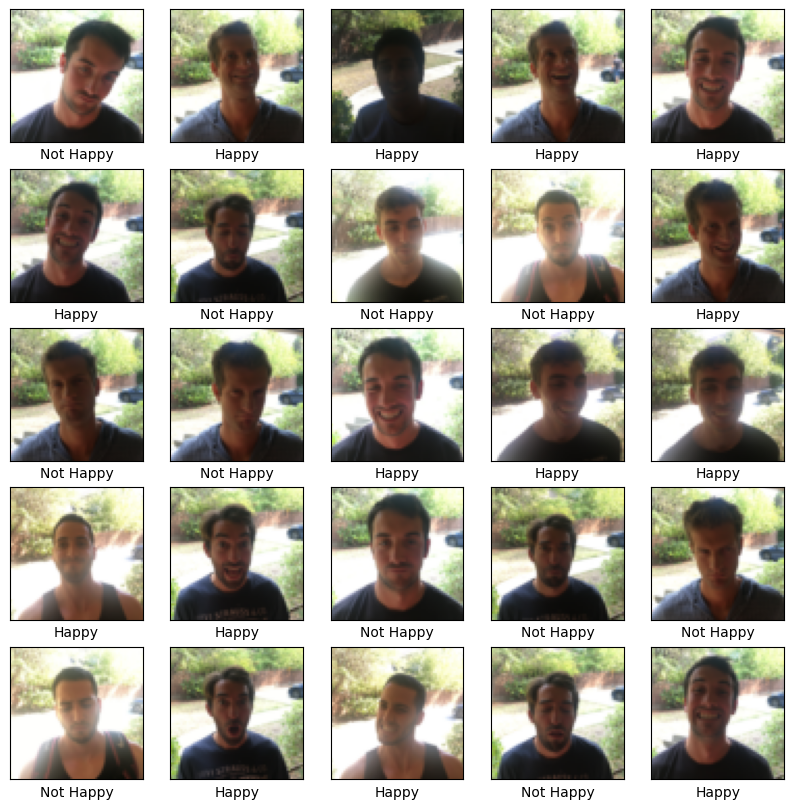

In [5]:
print("Number of training examples:", normalized_train.shape[0])
print("Number of testing examples:", normalized_test.shape[0])
print("Each image is of size:", normalized_train.shape[1:])
print("Training set label values:", np.unique(train_set_y))

# Assuming binary classification for simplicity
unique, counts = np.unique(train_set_y, return_counts=True)
print("Distribution of training labels:", dict(zip(unique, counts)))

# Visualize the first few training images
plt.figure(figsize=(10,10))
for i in range(25):  # display first 25 images
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_set_x[i], cmap=plt.cm.binary)
    plt.xlabel('Happy' if train_set_y[i]==1 else 'Not Happy')
plt.show()

<a name='2'></a>
## <font color='darkviolet'> 2 - Creating the Sequential Model

Constructing a Sequential model in Keras entails assembling a sequence of layers within the Sequential constructor. These layers collectively define the architecture of your ConvNet, and the order in which you arrange them determines the sequence of transformations applied to the input data.

It's important to note that in Keras, you must specify the input shape for your model. This is because the shape of the layer weights is determined by the shape of the inputs.

<a name='ex-2'></a>
### <font color='blue'> Exercise 2 - happyModel

<font color='blue'>**2.1** <font color='black'>Implement the `happyModel` function to create a specific ConvNet model with the following layers: `ZeroPadding2D -> Conv2D -> BatchNormalization -> ReLU -> MaxPooling2D -> Flatten -> Dense`.
    
You can use the documentation for reference: [tf.keras.layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers).

Here are the configuration details for each layer:
    
 - ZeroPadding2D: apply padding of 3 pixels to the input shape.
 - Conv2D: use 32 filters of size 7x7 with a stride of 1.
 - BatchNormalization: perform batch normalization along the depth axis (i.e., the channels or feature maps).
 - ReLU: apply Rectified Linear Unit activation function.
 - MaxPool2D: use default parameters for max pooling.
 - Flatten: flatten the previous output.
 - Fully-connected (Dense) layer: add a fully connected layer with 1 neuron and a sigmoid activation.

You can introduce these layers into a Sequential model using the `.add()` method. 
    
Note: Batch Normalization (BN) normalizes the inputs to a layer by subtracting the mean and dividing by the standard deviation of the mini-batch. This centers the data around zero and scales it to have a standard deviation of one. The mean and variance for each channel are computed during training and remain constant during inference. After normalization, BN introduces learnable parameters, gamma and beta, for each channel in the layer. Gamma values allow the network to increase or decrease the importance of each channel's features, while the beta parameter enables fine adjustments to the normalized values for a better fit to the training data.

In [6]:
def happyModel():

    model = Sequential()

    model.add(tfl.ZeroPadding2D(padding=(3, 3), input_shape=(64,64,3)))

    model.add(tfl.Conv2D(32, (7, 7), strides=(1, 1)))
    
    model.add(tfl.BatchNormalization(axis=3))
    
    model.add(tfl.ReLU())
    
    model.add(tfl.MaxPooling2D())
    
    model.add(tfl.Flatten())
    
    model.add(tfl.Dense(1, activation="sigmoid"))

    return model

In [7]:
# Test the model implementation
happy_model = happyModel()
# Print a summary for each layer
for layer in summary(happy_model):
    print(layer)
# The expected layer configurations
output = [['ZeroPadding2D', (None, 70, 70, 3), 0, ((3, 3), (3, 3))],
            ['Conv2D', (None, 64, 64, 32), 4736, 'valid', 'linear', 'GlorotUniform'],
            ['BatchNormalization', (None, 64, 64, 32), 128],
            ['ReLU', (None, 64, 64, 32), 0],
            ['MaxPooling2D', (None, 32, 32, 32), 0, (2, 2), (2, 2), 'valid'],
            ['Flatten', (None, 32768), 0],
            ['Dense', (None, 1), 32769, 'sigmoid']]
comparator(summary(happy_model), output)

['ZeroPadding2D', (None, 70, 70, 3), 0, ((3, 3), (3, 3))]
['Conv2D', (None, 64, 64, 32), 4736, 'valid', 'linear', 'GlorotUniform']
['BatchNormalization', (None, 64, 64, 32), 128]
['ReLU', (None, 64, 64, 32), 0]
['MaxPooling2D', (None, 32, 32, 32), 0, (2, 2), (2, 2), 'valid']
['Flatten', (None, 32768), 0]
['Dense', (None, 1), 32769, 'sigmoid']
All tests passed!


<font color='blue'>**2.2** <font color='black'> After designing the deep learning model, the next step is to compile it for training. In the context of TensorFlow and other deep learning frameworks, compiling a model involves configuring various settings that dictate how the training process will proceed. Set the following configurations:

- Optimizer: Select the "Adam" optimizer with a learning rate of 0.0001.
- Loss Function: Specify the "binary_crossentropy" loss function, ideal for binary classification tasks like distinguishing between smiling and non-smiling faces.
- Metrics: Monitor the "accuracy" metric during the training process to assess model performance.

In [8]:
happy_model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

<font color='blue'> **Q2.1** Execute the following line: `happy_model.summary()`. What is the distinction between trainable and non-trainable parameters? Can you identify the source of the 64 non-trainable parameters?

<font color='green'> The non trainable parameters are those that cannot be readjusted by the back propagation algorithm, they stay fixed. In this case I would guess they are coming from the batch normalization layer, since we know the parameters from the CNN and the Dense layers are indeed trainable
    
<font color='blue'> **Q2.2** How are the total parameters reported per layer calculated? Make the computations and verify your results with the `happy_model.summary()` ouput.

<font color='green'> To calculate the parameters we have to look at each layer individually. For instance, for the CNN, we have to multiply the size of the kernel, in this case 7x7 by the number of channels (3) and add the bias, to then multiply it by the number of filters we want to apply (32) --> Number of parameters=(Filter Height × Filter Width × Input Channels +1) × Number of Filters = 4736
For the dense layers, we would just multiply the number of input features + their bias by the number of neurons. In this case we have that the flatten layer output is 32768, so the number of parameters for the dense layer will be 1 x 32768 + 1 (bias).
    
<font color='blue'> **Q2.3** You might have noticed that the first output dimension of a layer is labeled as "None." Can you provide an explanation for this?

<font color='green'> In our case, we see None in that dimension because we haven´t specified any batch size, so the model is defined to be flexible with any batch size, which we will be able to set when training the model

In [9]:
happy_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 70, 70, 3)        0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        4736      
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                        

<a name='3'></a>
## <font color='darkviolet'> 3 - Training and Evaluating the Model

<font color='blue'>**3.1** <font color='black'> After creating and compiling your model, the next step is to initiate the training process. This is accomplished by calling `.fit()`. This method leverages the underlying TensorFlow framework to automate various aspects of the training process, including backpropagation.

The training process may include 20 epochs, a batch size of 32, and a validation split of 80% for training and 20% for validation to monitor the model's performance.

You can use the **`ModelCheckpoint`** callback in conjunction with `.fit()` to specify criteria for saving the best model automatically. You can find more details about this callback in the Keras documentation https://keras.io/api/callbacks/model_checkpoint/. Additionally, you can use **`EarlyStopping`** in combination with `ModelCheckpoint`. It helps prevent overfitting by monitoring a specific metric, such as validation accuracy, and stopping training when this metric no longer improves for a certain number of epoch. More information about this callback can be found in the Keras documentation https://keras.io/api/callbacks/early_stopping/.
    
Note: The .fit() method in Keras returns a History object. This object contains information about the training process.

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    'best_model.h5',            # The filepath where the model will be saved
    monitor='val_accuracy',     # The performance metric to monitor
    save_best_only=True         # Only save a model if `val_accuracy` has improved
)

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',     # The performance metric to monitor
    patience=10                  # Number of epochs with no improvement after which training will be stopped
)

# Train the model
history = happy_model.fit(
    normalized_train, 
    train_set_y, 
    epochs=40, 
    batch_size=64, 
    validation_split=0.2,       # 20% of the data will be used as validation set
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/40
8/8 [==============================] - 3s 242ms/step - loss: 0.6703 - accuracy: 0.6250 - val_loss: 0.6796 - val_accuracy: 0.6250
Epoch 2/40
8/8 [==============================] - 1s 187ms/step - loss: 0.4810 - accuracy: 0.8021 - val_loss: 0.6701 - val_accuracy: 0.6250
Epoch 3/40
8/8 [==============================] - 2s 196ms/step - loss: 0.3936 - accuracy: 0.8479 - val_loss: 0.6483 - val_accuracy: 0.7833
Epoch 4/40
8/8 [==============================] - 1s 183ms/step - loss: 0.3349 - accuracy: 0.8771 - val_loss: 0.6374 - val_accuracy: 0.7667
Epoch 5/40
8/8 [==============================] - 1s 189ms/step - loss: 0.2964 - accuracy: 0.9000 - val_loss: 0.6281 - val_accuracy: 0.7583
Epoch 6/40
8/8 [==============================] - 2s 215ms/step - loss: 0.2575 - accuracy: 0.9250 - val_loss: 0.6131 - val_accuracy: 0.8417
Epoch 7/40
8/8 [==============================] - 2s 186ms/step - loss: 0.2279 - accuracy: 0.9437 - val_loss: 0.5978 - val_accuracy: 0.8417
Epoch 8/40
8/8 [====

<font color='blue'> **Q3.1** Observe the training history, including the changes in loss and accuracy over each epoch, for the training and validation dataset. Describe.

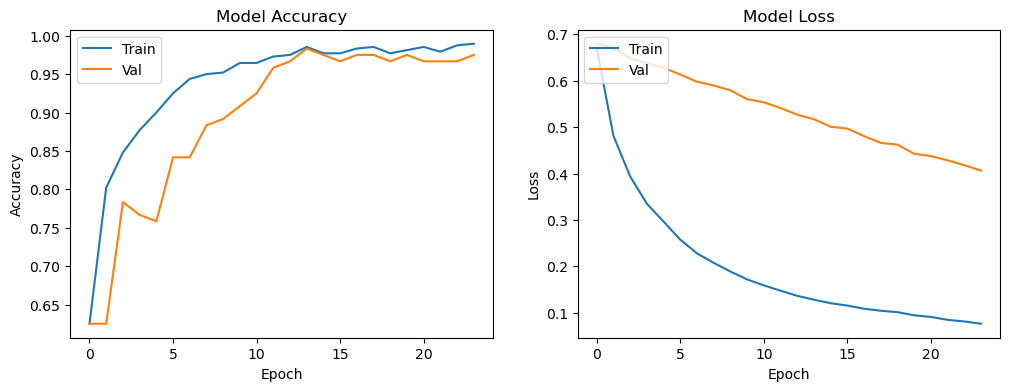

In [11]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()

We can see a normal model in which model accuracy keeps groing epoch after epoch and the loss keeps decreasing consequently. We can also see the difference between the validation and training data, having way less loss and way higher accuracy in the train test. This would become a problem when the validation metrics dont follow behind, meaning possible overfitting.

<font color='blue'>**3.2** <font color='black'>After training your model using `.fit()`, you can evaluate its performance on your test set by calling `.evaluate()`. This function returns the value of the loss function and any performance metrics you specified during compilation. The evaluation provides insights into **how well your model generalizes to unseen data and helps you assess its overall performance**. 

In [12]:
# Evaluate the model on the test data
test_loss, test_accuracy = happy_model.evaluate(normalized_test, test_set_y)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

5/5 [==============================] - 0s 19ms/step - loss: 0.4394 - accuracy: 0.9133
Test Loss: 0.43938493728637695
Test Accuracy: 0.9133333563804626


<font color='blue'> **Q3.2** How does the performance on the test dataset compare to the training performance you observed during the training process?

We can see the test performance to be the same as the evaluation one, 10% off the training set. This would mean that the model is not overfitted and that it generalizes decently well, since we are seeing a 90% accuracy in this test dataset, the same seen in validation. if this wasnt the case we would have to consider other options. In case we saw clear overfitting, we could think of using regularization technicques or simplifying the model. In case we saw underfitting, we could increase the number of parameters or even take a look at the data and check if we preprocessed it correctly. For instance, maybe we could perform some more advanced feature selections.

In [17]:
model = Sequential()

model.add(tfl.ZeroPadding2D(padding=(3, 3), input_shape=(64,64,3)))

model.add(tfl.Conv2D(32, (7, 7), strides=(1, 1)))

model.add(tfl.BatchNormalization(axis=3))

model.add(tfl.ReLU())

model.add(tfl.MaxPooling2D())

model.add(tfl.Flatten())

model.add(tfl.Dense(128, activation="relu"))

model.add(tfl.Dropout(0.4))

model.add(tfl.Dense(1, activation="sigmoid"))

In [18]:
# Train the model
history = happy_model.fit(
    normalized_train, 
    train_set_y, 
    epochs=40, 
    batch_size=64, 
    validation_split=0.2,       # 20% of the data will be used as validation set
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/40
8/8 [==============================] - 2s 188ms/step - loss: 0.0458 - accuracy: 0.9917 - val_loss: 0.2240 - val_accuracy: 0.9750
Epoch 2/40
8/8 [==============================] - 1s 177ms/step - loss: 0.0401 - accuracy: 0.9958 - val_loss: 0.2150 - val_accuracy: 0.9750
Epoch 3/40
8/8 [==============================] - 1s 168ms/step - loss: 0.0386 - accuracy: 0.9917 - val_loss: 0.2067 - val_accuracy: 0.9667
Epoch 4/40
8/8 [==============================] - 1s 182ms/step - loss: 0.0368 - accuracy: 0.9958 - val_loss: 0.2012 - val_accuracy: 0.9750
Epoch 5/40
8/8 [==============================] - 1s 175ms/step - loss: 0.0368 - accuracy: 0.9937 - val_loss: 0.1979 - val_accuracy: 0.9750
Epoch 6/40
8/8 [==============================] - 1s 173ms/step - loss: 0.0351 - accuracy: 0.9937 - val_loss: 0.1860 - val_accuracy: 0.9833
Epoch 7/40
8/8 [==============================] - 1s 170ms/step - loss: 0.0361 - accuracy: 0.9937 - val_loss: 0.1834 - val_accuracy: 0.9667
Epoch 8/40
8/8 [====

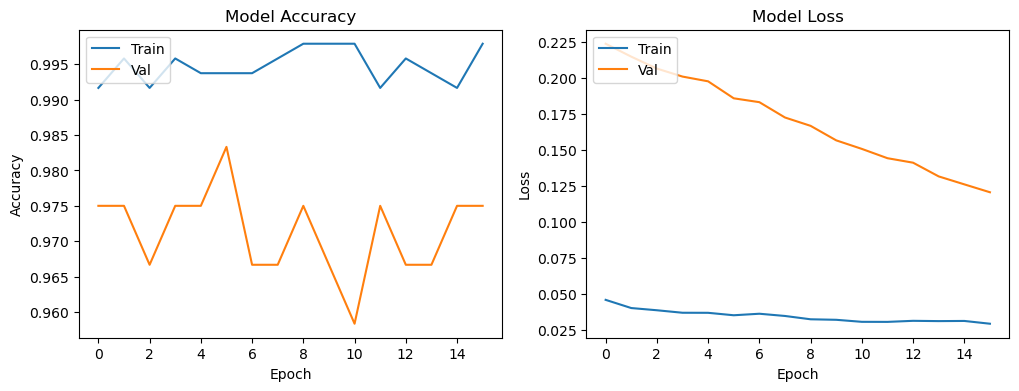

In [19]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()

In [20]:
# Evaluate the model on the test data
test_loss, test_accuracy = happy_model.evaluate(normalized_test, test_set_y)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

5/5 [==============================] - 0s 23ms/step - loss: 0.1581 - accuracy: 0.9467
Test Loss: 0.15811128914356232
Test Accuracy: 0.9466667175292969
